# Board Game Review Prediction

![](https://miro.medium.com/max/1200/0*6T4pngE_AXhiE30u)

### Contents
1. Abstract
2. Dataset.
3. Goal
4. Importing required libraries and dataset
5. Data Visualization on different factors
6. Prediction Models -
    - Spliting the dataset into 85:15 ratio
    - Deploying the models
        - OLS Regression
        - Decision Tree Regression
        - Random Forest Regression
        - Lasso Regression
        - Ridge Regression
        - MLP Regression
        - XgBoost Regression
        - Gradient Boosting Regression
7. Comparing the accuracy of the models
8. Conclusion

### Abstract
The game market is an increasingly large industry. The board-game market, which is the most traditional in the game market, continues to show a steady growth. It is very important for both publishers and players to predict the propensity of users in this huge market and to recommend new games. Despite its importance, no study has been performed on board-game recommendation systems. In this study, we propose a method to build a deep-learning-based recommendation system using large-scale user data of an online community related to board games. Our study showed that new games can be effectively recommended for board-game users based on user big data accumulated for a long time. This is the first study to propose a personalized recommendation system for users in the board-game market and to introduce a provision of new large datasets for board-game users. The proposed dataset shares symmetric characteristics with other datasets and has shown its ability to be applied to various recommendation systems through experiments. Therefore, the dataset and recommendation system proposed in this study are expected to be applied for various studies in the field.

### Dataset
The dataset is collected from Kaggle website. Here is the link : https://www.kaggle.com/gabrio/board-games-dataset

### Goal
The goal of this project are -
1. What are the categories of game that are the most popular?  
2. Can we build a model with the available data that predicts user rating? What factors make for the best "modern" board game

### Load relevant data, clean it, and begin exploring

In [1]:
#Import packages to be used
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline

#Load in the data and tell me something about it
import sqlite3
conn = sqlite3.connect('F:\octave projects\database.sqlite')
query = "SELECT * FROM BoardGames"
df_boardgame_full = pd.read_sql_query(query,conn)

In [2]:
#Let's look at what fields we have available
df_boardgame_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 81 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   row_names                                 90400 non-null  object 
 1   game.id                                   90400 non-null  object 
 2   game.type                                 90400 non-null  object 
 3   details.description                       90400 non-null  object 
 4   details.image                             83508 non-null  object 
 5   details.maxplayers                        90397 non-null  float64
 6   details.maxplaytime                       90397 non-null  float64
 7   details.minage                            90397 non-null  float64
 8   details.minplayers                        90397 non-null  float64
 9   details.minplaytime                       90397 non-null  float64
 10  details.name                      

In [3]:
#Parse down fields to those which describe attributes of the game
df_boardgame = df_boardgame_full.loc[:,
                                     ('game.id',
                                      'game.type',
                                      'details.description',
                                      'details.maxplayers',
                                      'details.maxplaytime',
                                      'details.minage',
                                      'details.minplayers',
                                      'details.minplaytime',
                                      'details.name',
                                      'details.playingtime',
                                      'details.yearpublished',
                                      'attributes.boardgamecategory',
                                      'attributes.boardgamemechanic',
                                      'attributes.boardgamepublisher',
                                      'stats.averageweight',
                                      'stats.average')]

## Data Visualization on different factors
Exploratory Data Analysis - does this for Machine Learning enthusiast. It is a way of visualizing, summarizing and interpreting the information that is hidden in rows and column format.

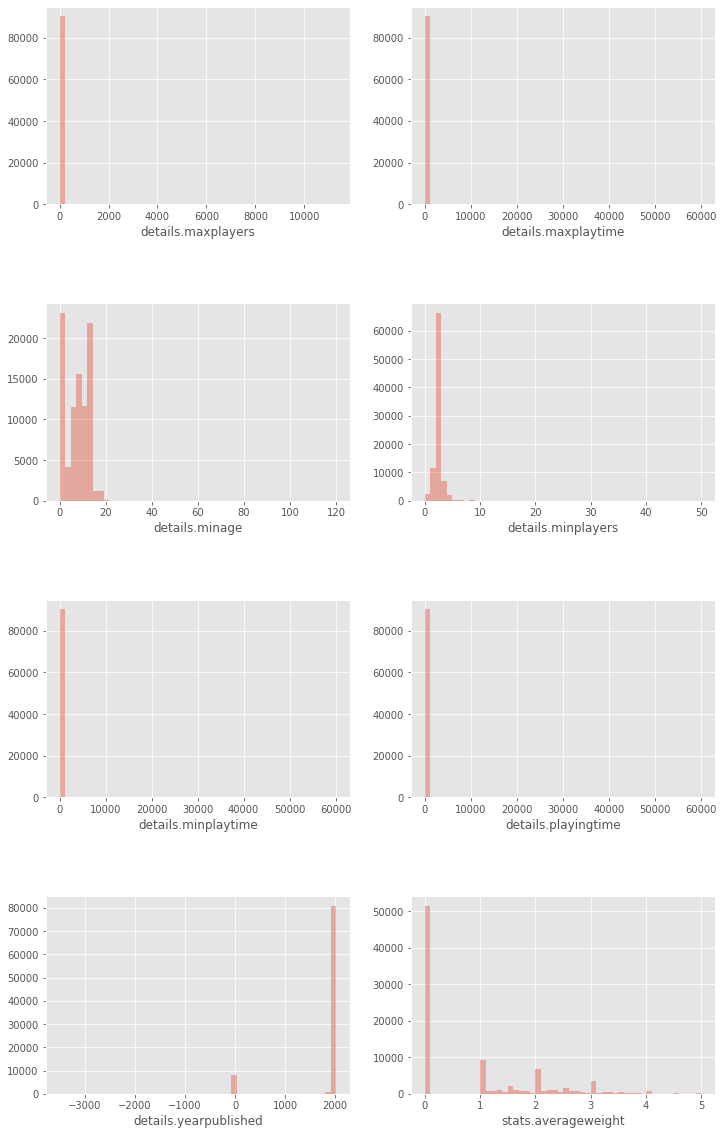

In [4]:
#Let's look at some distributions
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = df_boardgame.select_dtypes(include=numerics)
numdf = numdf.dropna(axis=0, how='any')
numdf_variables = list(numdf)

#Set the number of graphs in the facet chart
graphs = len(numdf_variables)-1

#create a list of positions for the chart
position = []
for i in range(4):
    for j in range(2):
        b = i,j
        position.append(b)

#Create base of subplot chart.. rows x columbs = graphs
fig, axes = plt.subplots(nrows=4, ncols=2, sharey=False, sharex=False, figsize=(12,20))
fig.subplots_adjust(hspace=.5)

#Fill in base with graphs based off of position
for i in range(graphs):
    sns.distplot(numdf[numdf_variables[i]], ax=axes[position[i]], kde=False)

Okay, so we have some variable outliers/errors here that are making the distributions way out of whack. There are many ways to deal with these outliers/errors, which we'll take on a case by case basis.

### Calculate outliers for all numeric details


In [5]:
#Calculate outliers for all numeric details
for field in numdf_variables:
    value_mean = df_boardgame[field].median()
    value_q1 = df_boardgame[field].quantile(.25)
    value_q3 = df_boardgame[field].quantile(.75)
    value_qrange = value_q3-value_q1
    lower_outlier = value_q1-(4.5 * value_qrange)
    upper_outlier = value_q3+(4.5 * value_qrange)
    print(field)
    print(len(df_boardgame[df_boardgame[field]>upper_outlier]), 'upper outliers at', upper_outlier)
    print(len(df_boardgame[df_boardgame[field]<lower_outlier]), 'lower outliers at', lower_outlier)


details.maxplayers
1135 upper outliers at 24.0
0 lower outliers at -16.0
details.maxplaytime
1141 upper outliers at 307.5
0 lower outliers at -242.5
details.minage
4 upper outliers at 66.0
0 lower outliers at -54.0
details.minplayers
9803 upper outliers at 2.0
14126 lower outliers at 2.0
details.minplaytime
1158 upper outliers at 285.0
0 lower outliers at -215.0
details.playingtime
1141 upper outliers at 307.5
0 lower outliers at -242.5
details.yearpublished
0 upper outliers at 2129.0
8760 lower outliers at 1869.0
stats.averageweight
0 upper outliers at 9.625
0 lower outliers at -7.875
stats.average
0 upper outliers at 36.666685
0 lower outliers at -30.000014999999998


This may be complicated. Let's deal with these outliers later.

### Correlation Matrix

stats.average            1.000000
stats.averageweight      0.511930
details.minage           0.238825
details.yearpublished    0.192503
details.playingtime      0.050798
details.maxplaytime      0.050798
details.minplaytime      0.046227
details.minplayers       0.000049
details.maxplayers      -0.001663
Name: stats.average, dtype: float64

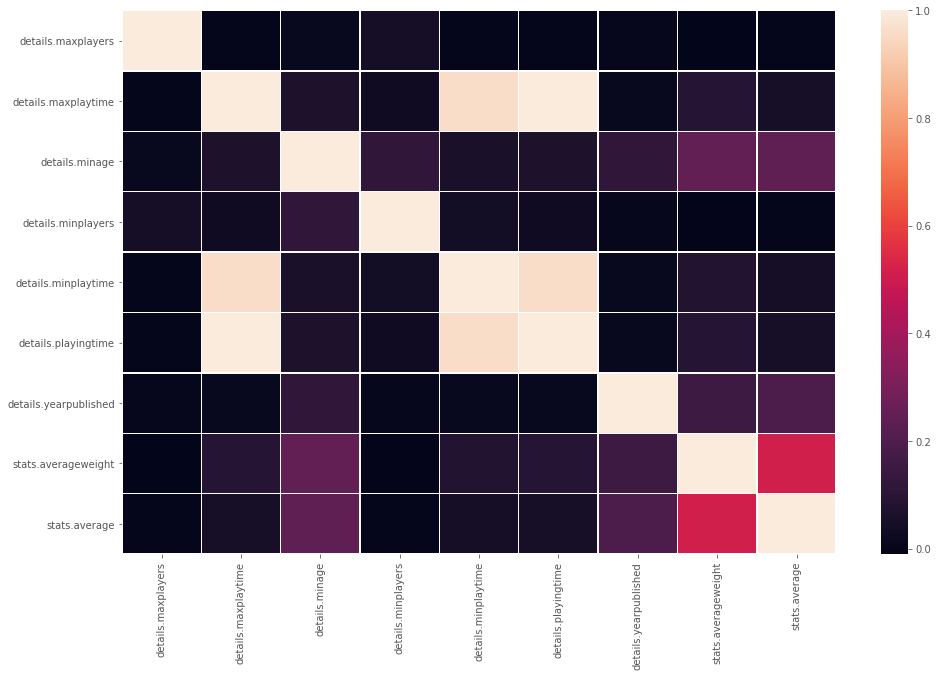

In [6]:
#Correlation Matrix
fig, ax = plt.subplots(figsize=(16,10))
corr = df_boardgame.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, linewidths=.5, ax=ax)
corr['stats.average'].sort_values(ascending=False)

The features most useful for us so far are:  stats.averageweight; details.yearpublished; details.minage

### Let's make a new dataframe to work on categorizing the boardgame correctly

In [7]:
#New manageable data frame
df_category = df_boardgame.loc[:, ['game.id','attributes.boardgamecategory']]
df_category['attributes.boardgamecategory'] = df_category['attributes.boardgamecategory'].fillna("None")

#Use comma splits to break out individual mechanical types
df_category = df_category['attributes.boardgamecategory'].apply(lambda x: pd.Series(x.split(',')))

#Sum the rows to determine most popular category types
category_counts = df_category.apply(pd.Series.value_counts).fillna(0)
category_counts['Total'] = category_counts.sum(axis=1)

#Let's get the most popular categories of games for our dataset
category_counts = category_counts.sort_values(by='Total', ascending=False)
category_list = category_counts[category_counts['Total']>500].index.tolist()

#Create dummies for all the boardgame categories
df_boardgame['attributes.boardgamecategory'].fillna(0, inplace=True)
for i in category_list:
    df_boardgame.loc[df_boardgame['attributes.boardgamecategory'].str.contains(i) == True ,i] = 1
    df_boardgame.loc[df_boardgame['attributes.boardgamecategory'].str.contains(i) == False ,i] = 0
    df_boardgame[i].fillna(0, inplace=True)

### Create a dataframe that takes boardgame categories and sorts by their overall mean rating

In [8]:
#Create a dataframe that takes boardgame categories and sorts by their overall mean rating
d =[]
for i in category_list:
    score = df_boardgame[df_boardgame[i]==1]['stats.average'].mean()
    d.append({'Avg_Rating': score, 'Game Type': i})
df_categorymean = pd.DataFrame(d).sort_values(by='Avg_Rating', ascending=False)
df_categorymean[:10]

,Avg_Rating,Game Type
69,6.447312,Renaissance
3,6.281217,Expansion for Base-game
58,6.035445,Civilization
19,5.789767,World War II
63,5.743018,World War I
27,5.722487,Medieval
7,5.711969,Miniatures
46,5.710972,City Building
51,5.677852,Napoleonic
47,5.604465,Trains


### Top rated and Lowest rated games categories

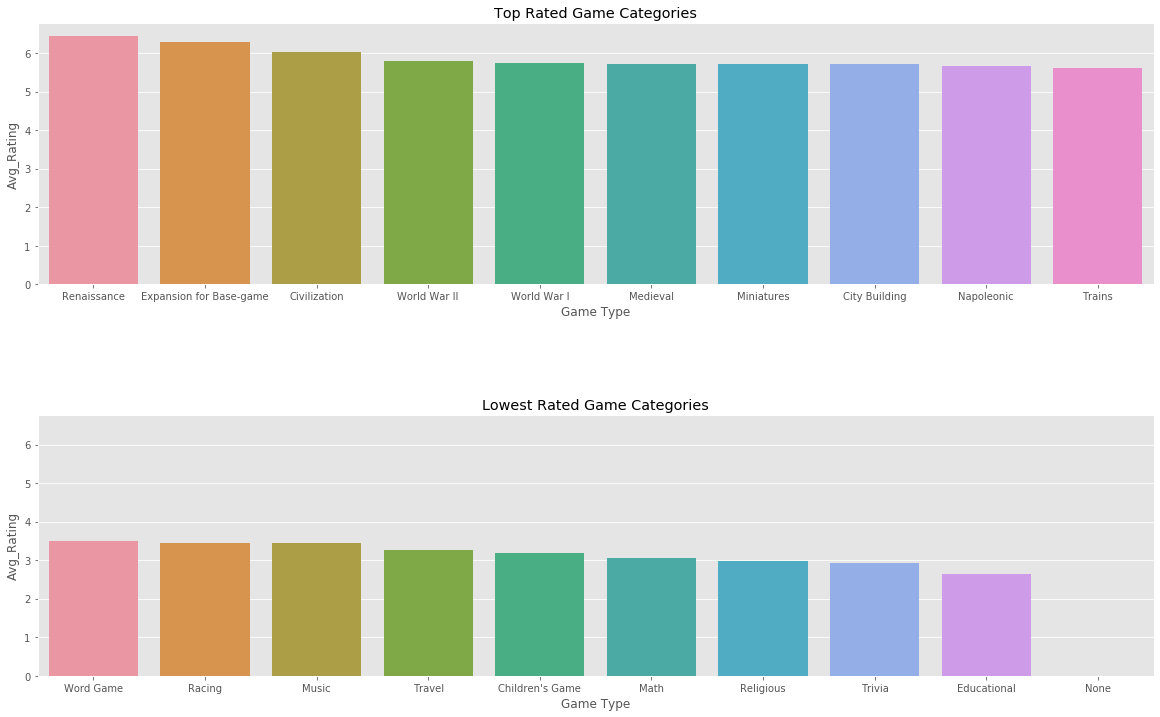

In [9]:
#Create base of subplot chart.. rows x columbs = graphs
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True, sharex=False, figsize=(20,12))
fig.subplots_adjust(hspace=.5)
sns.barplot(x="Game Type", y="Avg_Rating", data=df_categorymean[:10], ax=ax1)
sns.barplot(x="Game Type", y="Avg_Rating", data=df_categorymean[-10:], ax=ax2)
ax1.title.set_text('Top Rated Game Categories')
ax2.title.set_text('Lowest Rated Game Categories')

**Takeaways:**  
1) Let's make an period-piece expansion boardgame set in conflict involving trains  
2) Let's not try to incorporate school subjects into our boardgames

*************************************************
##   Prediction Model Creation

Predictive modeling, also called predictive analytics, is a mathematical process that seeks to predict future events or outcomes by analyzing patterns that are likely to forecast future results.

Now to build that prediction model I amgoing to use regression algorithms. Now let's find out what is regression algorithms?

Regression analysis consists of a set of machine learning methods that allow us to predict a continuous outcome variable (y) based on the value of one or multiple predictor variables (x). Briefly, the goal of regression model is to build a mathematical equation that defines y as a function of the x variables.

Here we are going to prepare several Regression machine learning models based on those we will do a comparative analysis that which model is better among them.

I have decided to go with nine regression models to evaluate this dataset - 

* **OLS Regression** : Ordinary least squares (OLS) regression is a statistical method of analysis that estimates the relationship between one or more independent variables and a dependent variable; the method estimates the relationship by minimizing the sum of the squares in the difference between the observed and predicted values of the dependent variable configured as a straight line.


* **Random Forest Regression** : Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression. A Random Forest operates by constructing several decision trees during training time and outputting the mean of the classes as the prediction of all the trees.


* **Decision Tree Regression** : Decision tree builds regression or classification models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. Decision trees can handle both categorical and numerical data.


* **Lasso Regression** : In statistics and machine learning, lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model.


* **Ridge Regression** : Ridge regression is a model tuning method that is used to analyse any data that suffers from multicollinearity. This method performs L2 regularization. When the issue of multicollinearity occurs, least-squares are unbiased, and variances are large, this results in predicted values to be far away from the actual values.


* **XgBoost Regressor** : XGBoost is a powerful approach for building supervised regression models. ... Ensemble learning involves training and combining individual models (known as base learners) to get a single prediction, and XGBoost is one of the ensemble learning methods.


* **MLP Regressor** : A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN). ... MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.


* **Gradient Boosting Regressor** : Gradient boosting is a machine learning technique for regression, classification and other tasks, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.



Let's deploy the models...

In [10]:
#Drop outliers for details.minage
df_boardgame = df_boardgame[df_boardgame['details.minage']<66]

#Drop "The Ancients" i.e. games that came out before 1900
df_boardgame = df_boardgame[df_boardgame['details.yearpublished']>1900]

'''
I don't like these details.maxplayers and details.maxplaytime, because 0s indicate the opposite
of their direction impact i.e. maxplayers = 0 indicates infinite players
'''

"\nI don't like these details.maxplayers and details.maxplaytime, because 0s indicate the opposite\nof their direction impact i.e. maxplayers = 0 indicates infinite players\n"

In [11]:
model_data = df_boardgame.loc[:,
                                     (
                                      'game.type',
                                      'details.minage',
                                      'details.minplayers',
                                      'details.yearpublished',
                                      'attributes.boardgamecategory',
                                      'stats.averageweight',
                                      'stats.average')]

In [12]:
#Create dummies for all the boardgame categories on model_data
for i in category_list:
    model_data.loc[model_data['attributes.boardgamecategory'].str.contains(i) == True ,i] = 1
    model_data.loc[model_data['attributes.boardgamecategory'].str.contains(i) == False ,i] = 0
    model_data[i].fillna(0, inplace=True)

In [13]:
#Get dummy variables for boardgame/expansion type
model_data = pd.get_dummies(model_data, columns=['game.type'])

In [14]:
#Get rid of remaining object categories
model_data = model_data.loc[:, model_data.columns != 'attributes.boardgamecategory']

**Training and Testing Dataset Spliting using the `train_test_split`**
  
  * Immporting the library from the sklearn.model_selection
  * Split the dataset into 85:15 ratio
  * x_train and y_train are the trainning datasets
  * x_test and y_test are the testing datasets
  * After the spliting of the datasets the model is ready to be prepared!

In [15]:
#Create Training / Test splits
from sklearn.model_selection import train_test_split

target_name = 'stats.average'
X = model_data.drop('stats.average', axis=1)
y=model_data[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=243)

### OLS Regression
Ordinary least squares (OLS) regression is a statistical method of analysis that estimates the relationship between one or more independent variables and a dependent variable; the method estimates the relationship by minimizing the sum of the squares in the difference between the observed and predicted values of the dependent variable configured as a straight line.

In [16]:
#Let's use the basic OLS regression from sklearn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

#What are the features that have the most weight?
ols_coefficients = pd.DataFrame({'feature': X_train.columns, 'importance': lm.coef_})
ols_coefficients.sort_values('importance', ascending=False)[:10]

,feature,importance
3,stats.averageweight,1.035134
73,Renaissance,0.958619
51,Trains,0.511242
31,Medieval,0.423839
45,Aviation / Flight,0.410483
29,Bluffing,0.372610
55,Napoleonic,0.368572
41,Real-time,0.320553
52,Pirates,0.310300
32,Deduction,0.308359


In [17]:
#Get OLS mean squared error on test dataset 
from sklearn import metrics
ols_y_predict = lm.predict(X_test)
ols_mse = np.sqrt(metrics.mean_squared_error(y_test, ols_y_predict))
ols_mse

2.3417666586137766

In [18]:
print(f'R2-Score: {metrics.r2_score(y_test, ols_y_predict)}')

R2-Score: 0.3472093833499533


### Random Forest Regression 
Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression. A Random Forest operates by constructing several decision trees during training time and outputting the mean of the classes as the prediction of all the trees.

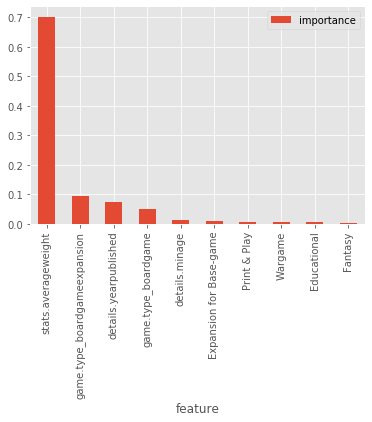

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=7, random_state=0)
rf.fit(X_train, y_train)
rf_importances = rf.feature_importances_
feat_names = X_train.columns
rf_result = pd.DataFrame({'feature': feat_names, 'importance': rf_importances})
rf_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar')

In [20]:
#Get Random Forest mean squared error on test dataset
rf_y_predict = rf.predict(X_test)
rf_mse = np.sqrt(metrics.mean_squared_error(y_test, rf_y_predict))
rf_mse

2.2270008236744814

In [21]:
print(f'R2-Score: {metrics.r2_score(y_test, rf_y_predict)}')

R2-Score: 0.40962572973950906


### Decision Tree Regressor
Decision tree builds regression or classification models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. Decision trees can handle both categorical and numerical data.

In [22]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [23]:
dtr_y_predict = dtr.predict(X_test)
dtr_mse = np.sqrt(metrics.mean_squared_error(y_test, dtr_y_predict))
dtr_mse

2.8269153580235855

In [24]:
print(f'R2-Score: {metrics.r2_score(y_test, dtr_y_predict)}')

R2-Score: 0.048711433537314885


### Lasso Regression
In statistics and machine learning, lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model.

In [25]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [26]:
lasso_y_predict = lasso.predict(X_test)
lasso_mse = np.sqrt(metrics.mean_squared_error(y_test, lasso_y_predict))
lasso_mse

2.389949076413906

In [27]:
print(f'R2-Score: {metrics.r2_score(y_test, lasso_y_predict)}')

R2-Score: 0.32007037957356943


### Ridge Regression

Ridge regression is a model tuning method that is used to analyse any data that suffers from multicollinearity. This method performs L2 regularization. When the issue of multicollinearity occurs, least-squares are unbiased, and variances are large, this results in predicted values to be far away from the actual values.

In [28]:
from sklearn import linear_model
ridge = linear_model.Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [29]:
ridge_y_predict = ridge.predict(X_test)
ridge_mse = np.sqrt(metrics.mean_squared_error(y_test, ridge_y_predict))
ridge_mse

2.341766677872332

In [30]:
print(f'R2-Score: {metrics.r2_score(y_test, ridge_y_predict)}')

R2-Score: 0.34720937261292784


### XgBoost Regressor 
XGBoost is a powerful approach for building supervised regression models. Ensemble learning involves training and combining individual models (known as base learners) to get a single prediction, and XGBoost is one of the ensemble learning methods.

In [31]:
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

[12:05:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [32]:
xgb_y_predict = xgb.predict(X_test)
xgb_mse = np.sqrt(metrics.mean_squared_error(y_test, xgb_y_predict))
xgb_mse

2.2301457644699085

In [33]:
print(f'R2-Score: {metrics.r2_score(y_test, xgb_y_predict)}')

R2-Score: 0.4079571150670196


### Gradient Boosting Regressor 
Gradient boosting is a machine learning technique for regression, classification and other tasks, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [35]:
gb_y_predict = gb.predict(X_test)
gb_mse = np.sqrt(metrics.mean_squared_error(y_test, gb_y_predict))
gb_mse

2.229192160009136

In [36]:
print(f'R2-Score: {metrics.r2_score(y_test, gb_y_predict)}')

R2-Score: 0.40846331877773456


### MLP Regressor 
A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN). MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

In [37]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
mlp.fit(X_train, y_train)

MLPRegressor()

In [38]:
mlp_y_predict = mlp.predict(X_test)
mlp_mse = np.sqrt(metrics.mean_squared_error(y_test, mlp_y_predict))
mlp_mse

2.866377803474747

In [39]:
print(f'R2-Score: {metrics.r2_score(y_test, mlp_y_predict)}')

R2-Score: 0.02196695045341268


***************************
### Comparative analysis among the algorithms for this project

We have deployed eight machine learning algorithms and every algorithm is deployed successfully without any hesitation. We have checked the accuracy of the models based on the accuracy score of each of the models. Now let's take a look at the scores of each models.

|Name of the Model|R2 Score|Mean Squared Error|
|:---:|:---:|:---:|
|OLS Regression|0.35|2.34|
|Decision Tree Regressor|0.05|2.83|
|Random Forest Regressor|0.41|2.23|
|Lasso Regression|0.32|2.39|
|Ridge Regression|0.35|2.34|
|XgBoost Regressor|0.41|2.23|
|MLP Regressor|0.02|2.86|
|Gradient Boosting Regressor|0.41|2.23|


### Conclusion

**Comparing all those scores scored by the machine learning algorithms, it is clear that Gradient Boosting Regression, XgBoosting Regression and Random Forest Regression are having the upper hand in case of this dataset and after this, we can use Ridge Regressor, which is also having good score as compared to the other deployed algorithms**

Best Fitted Models ranking - 
1. Gradient Boosting
2. XgBoosting Regressor
3. Random Forest
4. OLS Regression
5. Ridge Regressor
6. Lasso Regressor
7. Decision Tree Regressor
8. MLP Regressor



Hooray!! The models are deployed successfully!

## Hope this project will help you! Thank you!